Goal
- explore tulu paper's results and see if I could fit data mixture to eval results, visualize task input-output dependendices.


some todo:
1. think about how to normalize input/output.
2. think about normalize w.r.t. number of training tokens, data points.
 

In [196]:
import os
from rosemary import jpt_setup; jpt_setup()
from rosemary import plt_scaled_colobar_ax

import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
instruct_datasets = [
    # human-authored
    'SuperNI',
    'CoT',
    'Flan V2',
    'Dolly',
    'Open Assistant 1',
    # gpt-generated
    'Self-instruct',
    'Unnatural Instructions',
    'Alpaca',
    'Code-Alpaca',
    'GPT4-Alpaca',
    'Baize',
    'ShareGPT',
]

p = len(instruct_datasets)

def encode_input(dataset):
    if dataset in ('LLaMa-13B', 'Vanilla LLaMa'):
        return [0]*p
    if dataset == 'Human mix':
        # FLAN V2, CoT, Dolly, and Open Assistant 1
        return [0,1,1,1,1,0,0,0,0,0,0,0]
    if dataset == 'H+GPT mix':
        # FLAN V2, CoT, Dolly, and Open Assistant 1, GPT4-Alpaca, Code-Alpaca, and ShareGPT.
        return [0,1,1,1,1,0,0,0,1,1,0,1]
    x = [0]*p
    i = datasets.index(dataset)
    x[i] = 1
    return x

In [160]:
data = [
    ['Vanilla LLaMa', 31.9, 35.2, 6.0, 9.0, 34.0, 33.3, 39.1, 9.5, 11.6, 18.3, None, None],
    ['SuperNI', 44.1, 43.4, 3.0, 4.0, 38.4, 1.9, 47.9, 7.1, 7.0, 11.7, 5.7, 18.3],
    ['CoT', 41.3, 42.5, 6.5, 27.5, 33.7, 31.3, 44.4, 8.5, 7.4, 17.3, 4.2, 22.4],
    ['Flan V2', 45.4, 47.1, 3.5, 13.0, 38.6, 36.1, 45.0, 8.3, 9.6, 12.9, 4.6, 22.4],
    ['Dolly', 38.0, 35.8, 5.0, 7.0, 27.2, 24.4, 43.6, 8.7, 11.1, 22.1, 12.7, 20.7],
    ['Open Assistant 1', 32.9, 29.7, 6.0, 6.5, 20.4, 29.5, 26.8, 7.8, 10.1, 20.4, 47.8, 23.8],
    ['Self-instruct', 35.7, 33.2, 4.0, 6.5, 29.9, 29.2, 35.4, 8.7, 6.2, 12.1, 7.5, 18.0],
    ['Unnatural Instructions', 42.9, 38.1, 3.5, 5.0, 31.4, 30.0, 36.3, 6.5, 10.3, 19.8, 8.2, 20.0],
    ['Alpaca', 41.5, 40.3, 7.0, 10.0, 32.6, 31.8, 31.2, 7.2, 13.2, 22.0, 21.1, 23.3],
    ['Code-Alpaca', 34.7, 34.5, 6.5, 7.5, 29.6, 30.5, 36.7, 10.5, 16.5, 29.2, 17.5, 22.6],
    ['GPT4-Alpaca', 42.6, 38.3, 6.5, 10.0, 28.5, 32.3, 23.6, 5.8, 13.2, 25.0, 57.0, 28.3],
    ['Baize', 40.3, 38.6, 3.5, 5.5, 30.6, 32.4, 29.8, 7.9, 12.2, 23.8, 23.5, 22.6],
    ['ShareGPT', 44.3, 40.0, 8.0, 9.5, 5.2, 32.6, 25.5, 8.9, 10.9, 21.6, 58.3, 26.9],
    ['Human mix', 46.2, 48.0, 4.5, 26.5, 35.6, 34.8, 42.2, 7.7, 9.4, 20.2, 29.4, 27.8],
    ['H+GPT mix', 44.5, 47.0, 6.0, 27.0, 38.1, 39.2, 45.7, 7.7, 17.5, 27.8, 48.3, 33.1]
]

evals = [
    ('MMLU', '0-shot'),
    ('MMLU', '5-shot'),
    ('GSM', 'Direct'),
    ('GSM', 'CoT'),
    ('BBH', 'Direct'),
    ('BBH', 'CoT'),
    ('TydiQA', 'GB'),
    ('TydiQA', 'CB'),
    ('Codex-Eval', 'P@1'),
    ('Codex-Eval', 'P@10'),
    ('AlpacaFarm', 'v Davinci-003'),
]

cols = [('Model', '')] + evals + [('Average', '')]
multi_columns = pd.MultiIndex.from_tuples(cols)
df = pd.DataFrame(data, columns=multi_columns)

## verify the numbers copied from pdf, processed by chatgpt is correct.
avg_major_column = df[evals].groupby(level=0, axis=1).mean()
avg_row = avg_major_column.mean(axis=1)
assert np.nanmean(avg_row.to_numpy() - df[('Average', '')].to_numpy())<0.01
df = df.drop(columns=[('Average','')])
##

df

Model   MMLU           GSM          BBH       TydiQA  \
                           0-shot 5-shot Direct   CoT Direct   CoT     GB   
0            Vanilla LLaMa   31.9   35.2    6.0   9.0   34.0  33.3   39.1   
1                  SuperNI   44.1   43.4    3.0   4.0   38.4   1.9   47.9   
2                      CoT   41.3   42.5    6.5  27.5   33.7  31.3   44.4   
3                  Flan V2   45.4   47.1    3.5  13.0   38.6  36.1   45.0   
4                    Dolly   38.0   35.8    5.0   7.0   27.2  24.4   43.6   
5         Open Assistant 1   32.9   29.7    6.0   6.5   20.4  29.5   26.8   
6            Self-instruct   35.7   33.2    4.0   6.5   29.9  29.2   35.4   
7   Unnatural Instructions   42.9   38.1    3.5   5.0   31.4  30.0   36.3   
8                   Alpaca   41.5   40.3    7.0  10.0   32.6  31.8   31.2   
9              Code-Alpaca   34.7   34.5    6.5   7.5   29.6  30.5   36.7   
10             GPT4-Alpaca   42.6   38.3    6.5  10.0   28.5  32.3   23.6   
11                   Baize   40.3   38.6    3.5   5.5   30.6  32.4   29.8   
12                ShareGPT   44.3   40.0    8.0   9.5    5.2  32.6   25.5   
13               Human mix   46.2   48.0    4.5  26.5   35.6  34.8   42.2   
14               H+GPT mix   44.5   47.0    6.0  27.0   38.1  39.2   45.7   

         Codex-Eval          AlpacaFarm  
      CB        P@1  P@10 v Davinci-003  
0    9.5       11.6  18.3           NaN  
1    7.1        7.0  11.7           5.7  
2    8.5        7.4  17.3           4.2  
3    8.3        9.6  12.9           4.6  
4    8.7       11.1  22.1          12.7  
5    7.8       10.1  20.4          47.8  
6    8.7        6.2  12.1           7.5  
7    6.5       10.3  19.8           8.2  
8    7.2       13.2  22.0          21.1  
9   10.5       16.5  29.2          17.5  
10   5.8       13.2  25.0          57.0  
11   7.9       12.2  23.8          23.5  
12   8.9       10.9  21.6          58.3  
13   7.7        9.4  20.2          29.4  
14   7.7       17.5  27.8          48.3

In [161]:

evals_subset = [
    ('MMLU', '0-shot'),
    ('MMLU', '5-shot'),
    ('GSM', 'Direct'),
    ('GSM', 'CoT'),
    ('BBH', 'Direct'),
    ('BBH', 'CoT'),
    ('Codex-Eval', 'P@1'),
]
output_names = [f'{x}_{y}' for x, y in evals_subset]

dfs = df.copy()
dfs = dfs[evals_subset]
dfs.columns = output_names
dfs

,MMLU_0-shot,MMLU_5-shot,GSM_Direct,GSM_CoT,BBH_Direct,BBH_CoT,Codex-Eval_P@1
0,31.9,35.2,6.0,9.0,34.0,33.3,11.6
1,44.1,43.4,3.0,4.0,38.4,1.9,7.0
2,41.3,42.5,6.5,27.5,33.7,31.3,7.4
3,45.4,47.1,3.5,13.0,38.6,36.1,9.6
4,38.0,35.8,5.0,7.0,27.2,24.4,11.1
5,32.9,29.7,6.0,6.5,20.4,29.5,10.1
6,35.7,33.2,4.0,6.5,29.9,29.2,6.2
7,42.9,38.1,3.5,5.0,31.4,30.0,10.3
8,41.5,40.3,7.0,10.0,32.6,31.8,13.2
9,34.7,34.5,6.5,7.5,29.6,30.5,16.5


In [171]:
X = [encode_input(x[0]) for x in data]
X = np.array(X)
y = dfs.to_numpy()

X_train = X[:-2]
y_train = y[:-2]

X_test = X[-2:]
y_test = y[-2:]

# `y` is the performance delta between base model and instruction tuned model 
base_model_perf = y_train[0,:].copy()
y_train = y_train-base_model_perf
X_train = X_train[1:]; y_train = y_train[1:]
y_test = y_test-base_model_perf

print(X_train)
print(y_train)
print(X_test)
print(y_test)

[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]]
[[ 12.2   8.2  -3.   -5.    4.4 -31.4  -4.6]
 [  9.4   7.3   0.5  18.5  -0.3  -2.   -4.2]
 [ 13.5  11.9  -2.5   4.    4.6   2.8  -2. ]
 [  6.1   0.6  -1.   -2.   -6.8  -8.9  -0.5]
 [  1.   -5.5   0.   -2.5 -13.6  -3.8  -1.5]
 [  3.8  -2.   -2.   -2.5  -4.1  -4.1  -5.4]
 [ 11.    2.9  -2.5  -4.   -2.6  -3.3  -1.3]
 [  9.6   5.1   1.    1.   -1.4  -1.5   1.6]
 [  2.8  -0.7   0.5  -1.5  -4.4  -2.8   4.9]
 [ 10.7   3.1   0.5   1.   -5.5  -1.    1.6]
 [  8.4   3.4  -2.5  -3.5  -3.4  -0.9   0.6]
 [ 12.4   4.8   2.    0.5 -28.8  -0.7  -0.7]]
[[0 1 1 1 1 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 0 1 1 0 1]]
[[14.3 12.8 -1.5 17.5  1.6  1.5 -2.2]
 [12.6 11.8  0.  18.   4.1  5.9  5.9]]


In [239]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, ElasticNet, Lasso
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso

reg = MultiOutputRegressor(ElasticNet(
    random_state=123, 
    fit_intercept=False,
    alpha=1,
    l1_ratio=.5
))
reg.fit(X_train, y_train)
reg

MultiOutputRegressor(estimator=ElasticNet(alpha=1, fit_intercept=False,
                                          random_state=123))

MSE: 84.44


<Axes: title={'center': 'Compare `y_pred` and `y_test` '}, ylabel='y_pred           y_test'>

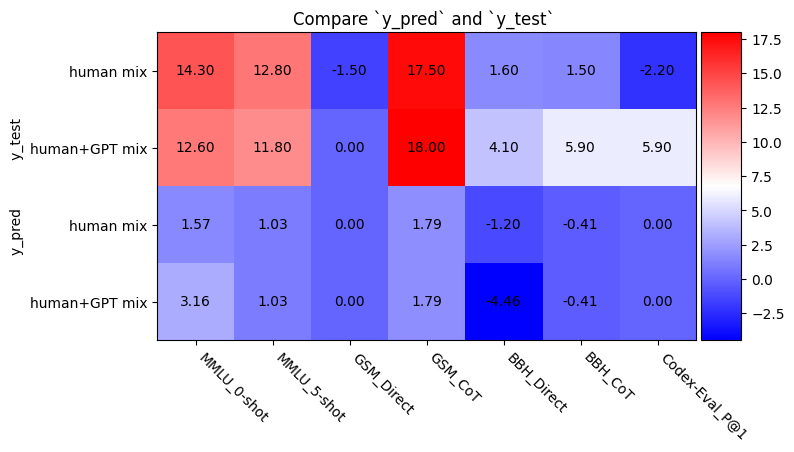

In [240]:
from rosemary import plt_kernel_matrix_one

y_pred = reg.predict(X_test)
print(f'MSE: {sklearn.metrics.mean_squared_error(y_test, y_pred):.2f}')

fig, ax = plt.subplots(1,1,figsize=(8,4))
y_test_pred = np.vstack([y_test,
                         y_pred])
plt_kernel_matrix_one(fig, ax, y_test_pred, custom_ticks=False, annotate=True, cmap='bwr')
ax.set_ylabel('y_pred           y_test')
ax.set_xticks(list(range(len(output_names))), output_names, rotation=-45, ha='left')
ylabels = ['human mix', 'human+GPT mix']*2
ax.set_yticks(list(range(len(ylabels))), ylabels)

ax.set_title('Compare `y_pred` and `y_test` ')
ax

In [228]:
W = np.stack([reg.estimators_[i].coef_ for i in range(len(reg.estimators_))]).T
b = np.stack([reg.estimators_[i].intercept_ for i in range(len(reg.estimators_))]).T

with np.printoptions(precision=2, suppress=True):
    print(W.shape, b.shape)
    print(W)
    print('intersept:  ', b)
    print('base model: ', [31.9,35.2,6.0,9.0,34.0,33.3,11.6])

(12, 7) (7,)
[[  0.2   0.   -0.   -0.    0.  -19.4  -0. ]
 [  0.    0.    0.    6.5  -0.   -0.   -0. ]
 [  1.5   0.   -0.    0.    0.    0.   -0. ]
 [  0.    0.   -0.   -0.   -0.   -0.   -0. ]
 [  0.   -0.    0.   -0.   -1.6  -0.   -0. ]
 [  0.   -0.   -0.   -0.   -0.   -0.   -0. ]
 [  0.    0.   -0.   -0.   -0.   -0.   -0. ]
 [  0.    0.    0.    0.   -0.   -0.    0. ]
 [  0.   -0.    0.   -0.   -0.   -0.    0. ]
 [  0.    0.    0.    0.   -0.   -0.    0. ]
 [  0.    0.   -0.   -0.   -0.   -0.    0. ]
 [  0.4   0.    0.    0.  -16.8  -0.   -0. ]]
intersept:   [0. 0. 0. 0. 0. 0. 0.]
base model:  [31.9, 35.2, 6.0, 9.0, 34.0, 33.3, 11.6]


<Axes: xlabel='Output', ylabel='Input'>

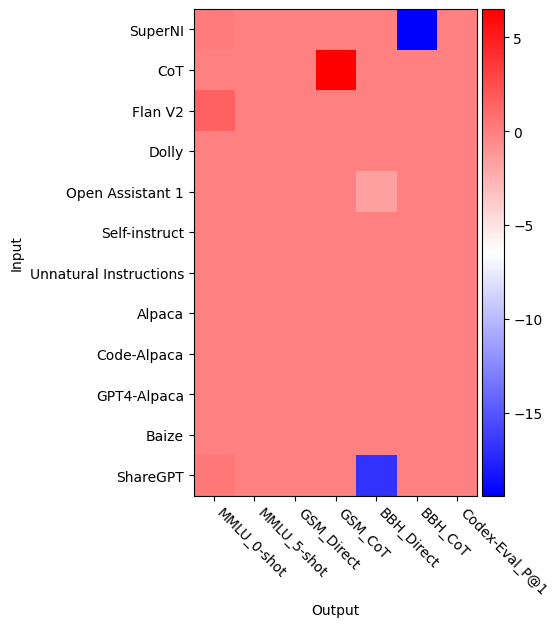

In [229]:

fig, ax = plt.subplots(1,1,figsize=(4,7))
im = ax.imshow(W, cmap='bwr')
fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
ax.set_ylabel('Input')
ax.set_xlabel('Output')
ax.set_yticks(list(range(len(instruct_datasets))), instruct_datasets)
ax.set_xticks(list(range(len(output_names))), output_names, rotation=-45, ha='left')
ax